In [185]:
# from google.colab import drive
# drive.mount('/content/drive')

In [186]:
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras

In [187]:
# Model Definition

# Modality Specific Module
class ModalitySpecificModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)  
    # Text MSM Layers
    self.bigru_text = keras.layers.Bidirectional(keras.layers.GRU(32))
    self.msl_1_text = keras.layers.Dense(32, activation='relu')
    self.msl_2_text = keras.layers.Dense(64, activation='relu')
    # Audio MSM Layers
    self.bigru_audio = keras.layers.Bidirectional(keras.layers.GRU(32))
    self.msl_1_audio = keras.layers.Dense(32, activation='relu')
    self.msl_2_audio = keras.layers.Dense(64, activation='relu')
    # Visual MSM Layers
    self.bigru_visual = keras.layers.Bidirectional(keras.layers.GRU(32))
    self.msl_1_visual = keras.layers.Dense(32, activation='relu')
    self.msl_2_visual = keras.layers.Dense(64, activation='relu')

  def __call__(self, text_input, audio_input, visual_input):
    # Text MSM
    bigru_text_output = self.bigru_text(text_input)
    msl_l1_text = self.msl_1_text(bigru_text_output)
    text_msm_output = self.msl_2_text(msl_l1_text)
    # Audio MSM
    bigru_audio_output = self.bigru_audio(audio_input)
    msl_l1_audio = self.msl_1_audio(bigru_audio_output)
    audio_msm_output = self.msl_2_audio(msl_l1_audio)
    # Visual MSM
    bigru_visual_output = self.bigru_visual(visual_input)
    msl_l1_visual = self.msl_1_visual(bigru_visual_output)
    visual_msm_output = self.msl_2_visual(msl_l1_visual)

    return text_msm_output, audio_msm_output, visual_msm_output


# Dense Multimodal Fusion Module
class DenseMultimodalFusionModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.residual_features = []

  def df_wrapper(self, f1, f2, f3, n):
    for i in range(n):
      f1, f2, f3 = self.df_layer(f1, f2, f3)
    r = keras.layers.Add()([f1, f2, f3])
    self.residual_features.append(r)
    return self.residual_features

  # df layer
  def df_layer(self, f1, f2, f3):
    r = keras.layers.Add()([f1, f2, f3])
    self.residual_features.append(r)
    # concatenation before feeding to df block
    df_input1 = keras.layers.Concatenate()([f1, f3])
    df_input2 = keras.layers.Concatenate()([f1, f2])
    df_input3 = keras.layers.Concatenate()([f2, f3])
    # df block
    df_output1 = keras.layers.Dense(64, activation='relu')(df_input1)
    df_output2 = keras.layers.Dense(64, activation='relu')(df_input2)
    df_output3 = keras.layers.Dense(64, activation='relu')(df_input3)

    return df_output1, df_output2, df_output3

  def __call__(self, f1_0, f2_0, f3_0):
    DF_LAYER_COUNT = 6
    residual = self.df_wrapper(f1_0, f2_0, f3_0, DF_LAYER_COUNT)
    return residual


# Multimodal Residual Module
class MultimodalResidualModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, residual_features):
    final_residual_feature = keras.layers.Add()(residual_features)
    return final_residual_feature


# Sentiment Classification Module
class SentimentClassificationModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer_1 = keras.layers.Dense(128, activation='relu')
    self.layer_2 = keras.layers.Dense(64, activation='relu')
    self.layer_3 = keras.layers.Dense(32, activation='relu')
    self.layer_4 = keras.layers.Dense(16, activation='relu')
    num_classes = 7
    self.classification_layer = keras.layers.Dense(num_classes, activation='softmax')

  def __call__(self, residual_feature):
    output_l1 = self.layer_1(residual_feature)
    output_l2 = self.layer_2(output_l1)
    output_l3 = self.layer_3(output_l2)
    output_l4 = self.layer_4(output_l3)
    sentiment = self.classification_layer(output_l4)
    return sentiment

# deep dense fusion network with multimodal residual (DFMR)
class DFMR(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.text_input = keras.Input(shape=(50, 300))
    self.audio_input = keras.Input(shape=(50, 5))
    self.visual_input = keras.Input(shape=(50, 20))

    # Major Modules of DFMR
    self.msm = ModalitySpecificModule()
    self.dmfm = DenseMultimodalFusionModule()
    self.mrm = MultimodalResidualModule()
    self.scm = SentimentClassificationModule()

  def __call__(self):
    # major module structure overview
    text_msm_output, audio_msm_output, visual_msm_output = self.msm(self.text_input, self.audio_input, self.visual_input)
    residual_features = self.dmfm(text_msm_output, audio_msm_output, visual_msm_output)
    final_residual_feature = self.mrm(residual_features)
    output = self.scm(final_residual_feature)    
    # model definition
    model = keras.Model(inputs=[self.text_input, self.audio_input, self.visual_input], outputs=output)
    return model


dfmr_model = DFMR()
model = dfmr_model()
model.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_57      │ (None, 50, 300)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_58      │ (None, 50, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_59      │ (None, 50, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_57    │ (None, 64)        │     64,128 │ input_layer_57[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_58    │ (None, 64)        │      7,488 │ input_layer_58[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_59    │ (None, 64)        │     10,368 │ input_layer_59[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_467 (Dense)   │ (None, 32)        │      2,080 │ bidirectional_57… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_469 (Dense)   │ (None, 32)        │      2,080 │ bidirectional_58… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_471 (Dense)   │ (None, 32)        │      2,080 │ bidirectional_59… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_468 (Dense)   │ (None, 64)        │      2,112 │ dense_467[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_470 (Dense)   │ (None, 64)        │      2,112 │ dense_469[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_472 (Dense)   │ (None, 64)        │      2,112 │ dense_471[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_258     │ (None, 128)       │          0 │ dense_468[0][0],  │
│ (Concatenate)       │                   │            │ dense_472[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_259     │ (None, 128)       │          0 │ dense_468[0][0],  │
│ (Concatenate)       │                   │            │ dense_470[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_260     │ (None, 128)       │          0 │ dense_470[0][0],  │
│ (Concatenate)       │                   │            │ dense_472[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_478 (Dense)   │ (None, 64)        │      8,256 │ concatenate_258[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_479 (Dense)   │ (None, 64)        │      8,256 │ concatenate_259[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_480 (Dense)   │ (None, 64)        │      8,256 │ concatenate_260[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_261     │ (None, 128)       │          0 │ dense_478[0][0],  │
│ (Concatenate)       │                   │            │ dense_480[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_262     │ (None, 128)       │          0 │ dense_478[0][0],

 Total params: 262,471 (1.00 MB)

 Trainable params: 262,471 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [188]:
model.compile(
  optimizer='adam',
  loss=keras.losses.MeanAbsoluteError(),
  metrics=[
    keras.metrics.Accuracy()
  ]
)

In [189]:
# with open('/content/drive/MyDrive/Colab Notebooks/Multimodal Sentiment Analysis/mosi_data.pkl', 'rb') as fp:
#   data = pickle.load(fp)

with open('../dataset/mosi_data.pkl', 'rb') as fp:
  data = pickle.load(fp)

In [190]:
def convertLabels(label):
  result = 0
  if label < -2:
    result = -3
  elif -2 <= label and label < -1:
    result = -2
  elif -1 <= label and label < 0:
    result = -1
  elif 0 <= label and label <= 0:
    result = 0
  elif 0 < label and label <= 1:
    result = 1
  elif 1 < label and label <= 2:
    result = 2
  elif label > 2:
    result = 3
  rep = {
    -3 : [1., 0., 0., 0., 0., 0., 0.],
    -2 : [0., 1., 0., 0., 0., 0., 0.],
    -1 : [0., 0., 1., 0., 0., 0., 0.],
    0 : [0., 0., 0., 1., 0., 0., 0.],
    1 : [0., 0., 0., 0., 1., 0., 0.],
    2 : [0., 0., 0., 0., 0., 1., 0.],
    3 : [0., 0., 0., 0., 0., 0., 1.]
  }
  return tf.convert_to_tensor(rep[result])

def prepare_data(type):
  text_input = tf.convert_to_tensor(data[type]['text'])
  audio_input = tf.convert_to_tensor(data[type]['audio'])
  visual_input = tf.convert_to_tensor(data[type]['vision'])
  labels = [convertLabels(element) for element in data[type]['labels'][:, 0][:, 0]]
  labels = np.array(labels, dtype=np.float32)
  return text_input, audio_input, visual_input, labels

train_text_input, train_audio_input, train_visual_input, train_labels = prepare_data('train')
valid_text_input, valid_audio_input, valid_visual_input, valid_labels = prepare_data('valid')

In [191]:
training_dataset = [train_text_input, train_audio_input, train_visual_input]
validation_data = ([valid_text_input, valid_audio_input, valid_visual_input], valid_labels)

In [192]:
epochs = 50
history = model.fit(training_dataset, train_labels, validation_data=validation_data, epochs=epochs)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.0222 - loss: 0.2284 - val_accuracy: 0.3543 - val_loss: 0.2283
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4486 - loss: 0.2150 - val_accuracy: 0.4666 - val_loss: 0.2283
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5055 - loss: 0.2151 - val_accuracy: 0.4666 - val_loss: 0.2283
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4997 - loss: 0.2205 - val_accuracy: 0.4666 - val_loss: 0.2283
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5097 - loss: 0.2084 - val_accuracy: 0.4666 - val_loss: 0.2283
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.5035 - loss: 0.2111 - val_accuracy: 0.4666 - val_loss: 0.2283
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5028 - loss: 0.2126 - val_accuracy: 0.4666 - val_loss: 0.2283
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5051 - loss: 0.2108 - val_accuracy: 0.4666 - 

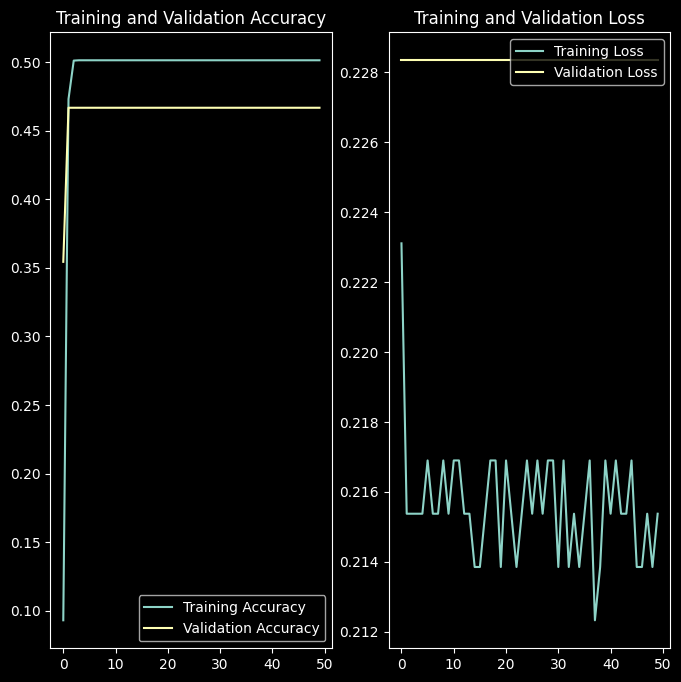

In [193]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [194]:
test_text_input, test_audio_input, test_visual_input, test_labels = prepare_data('test')
test_dataset = [test_text_input, test_audio_input, test_visual_input]

print("Evaluate on test data")
results = model.evaluate(test_dataset, test_labels)
print("test loss, test acc:", results)

Evaluate on test data
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4460 - loss: 0.2369
test loss, test acc: [0.23544760048389435, 0.47334450483322144]
